# Development
This is a working file in which I develop different elements of the project

### All libraries that I could possibly need

In [1]:
from twitter_cleaner import TweetCleaner
import pandas as pd
import time
import csv
import json
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import gc
import operator
import itertools
import pdb
import nltk
from nltk import FreqDist
import scipy as sp 
import collections
import random
import csv
from tqdm import trange
import datetime
import matplotlib.pyplot as plt
import os
import sys

## Cleaner

Clean the test folder

In [ ]:
tmp = json.load(open("cleaner.config","r"))
tmp.pop('test/fala.csv')
json.dump(tmp,open("cleaner.config","w"))
!cd test && ls | grep fala_clean | xargs rm

Run cleaner

In [ ]:
cleaner = TweetCleaner("cleaner.config")
begin = time.time()
cleaner.clean("data/fala.csv", "test/fala_clean.csv", 
              path_stopwords = "nlp/polish.stopwords.txt", chunk_size = 100000)
end = time.time()
print(f"Runtime {end - begin}")

## Estimator

In [2]:
gov_data = pd.read_csv("data/clean/gov_tweets_clean_2020_03_29.csv", header = 0, index_col = False, dtype = str)
gov_data["source"] = "government"
gov_data = gov_data.loc[gov_data.created_at.notna()]
gov_data = gov_data.drop(columns = ["index"])
gov_data["created_at"] = pd.to_datetime(gov_data["created_at"], format = "%a %b %d %H:%M:%S +0000 %Y")
gov_data["day"] = gov_data.created_at.dt.to_period("D")
gov_data = gov_data.loc[gov_data["day"] == pd.Period('2020-03-29', 'D')].reset_index()

In [3]:
opp_data = pd.read_csv("data/clean/opp_tweets_2020_03_29.csv", header = 0, index_col = False, dtype = str)
opp_data["source"] = "opposition"
opp_data = opp_data.loc[opp_data.created_at.notna()]
opp_data = opp_data.drop(columns = ["index"])
opp_data["created_at"] = pd.to_datetime(opp_data["created_at"], format = "%a %b %d %H:%M:%S +0000 %Y")
opp_data["day"] = opp_data.created_at.dt.to_period("D")
opp_data = opp_data.loc[opp_data["day"] == pd.Period('2020-03-29', 'D')].reset_index()

In [4]:
tweet_data = pd.concat([gov_data, opp_data], axis = 0)
del(gov_data)
del(opp_data)
gc.collect()

68

In [5]:
tweet_data.dropna(subset = ["source","preprocessed"], inplace = True)

In [6]:
def vectorize_data(data, ngram_range, limit):
    vectorizer = CountVectorizer(ngram_range = ngram_range)
    vectorizer.fit(data)
    res = vectorizer.transform(data)
    indices = np.where(np.array(res.sum(axis = 0)).flatten() > limit)[0]
    #names = vectorizer.get_feature_names()
    res = res[:,indices]
    #names = operator.itemgetter(*indices)(names)

    return res

## Plug-in estimator of partisanship

In [9]:
#vectorize the data
data = vectorize_data(tweet_data["preprocessed"],ngram_range = (2,2), limit = 10)

#speaker phrase counts
counts = dict()
zipper = zip(tweet_data["source"].tolist(), tweet_data["user-id_str"].tolist(), data)
for g, elem in itertools.groupby(zipper,lambda x: (x[0],x[1])):
    counts[g] = sp.sparse.vstack(list(i for _, _, i in elem))
counts = {k:np.array(v.sum(axis = 0)).flatten() for k, v in counts.items() if v.sum() > 0}
del(data, tweet_data)
gc.collect()

8

In [10]:
#Party-wise total phrase counts
party_counts = collections.defaultdict(lambda: [])
for g, elem in itertools.groupby(zip(counts.keys(), counts.values()), lambda x: x[0][0]):
    party_counts[g].extend(list(i for _,i in elem))

#empirical party frequencies
party_freq = {k:np.vstack(v).sum(axis = 0) for k, v in party_counts.items()}
party_freq = {k:v/v.sum() for k, v in party_freq.items()}

#posterior belief that an observer with neutral prior assigns the true party:
posterior = party_freq["government"]/(party_freq["government"] + party_freq["opposition"])


#partisanship plug-in estimator
plug_in = np.sum(0.5*party_freq["government"] * posterior + 0.5*party_freq["opposition"]*(1 - posterior))
print(plug_in)

0.780099488861822


## Leave-out estimator of partisanship

In [11]:
c_mat = sp.sparse.csr_matrix(np.vstack(list(counts.values())))
parties = np.array(list(party for party, id in counts.keys()))
indg = parties == "government"
indo = parties == "opposition"

In [12]:
leave_out = collections.defaultdict(lambda: [])
zipper = zip(counts.keys(), c_mat)
for i, (g, val) in enumerate(itertools.groupby(zipper, lambda x:x[0])):
    ind = np.arange(c_mat.shape[0]) != i
    qg = np.sum(c_mat[ind & indg], axis = 0)
    qo = np.sum(c_mat[ind & indo], axis = 0)
    leave_out[g[0]].extend(np.array(qg/(qo+qg)))
leave_out = {k:np.nan_to_num(np.vstack(v),copy = False,nan = 0.0) for k, v in leave_out.items()}

/home/piotr/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/piotr/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/piotr/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/piotr/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/piotr/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/piotr/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/piotr/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divid

In [13]:
speaker_freq = collections.defaultdict(lambda: [])
for g, elem in itertools.groupby(zip(parties, counts.values()), lambda x: x[0]):
    speaker_freq[g].extend(list(i/i.sum() for _, i in elem))
speaker_freq = {k:np.vstack(v) for k, v in speaker_freq.items()}

In [14]:
gov = 0.5*(1/len(speaker_freq["government"]))*np.sum(speaker_freq["government"] * leave_out["government"])
opp = 0.5*(1/len(speaker_freq["opposition"]))*np.sum(speaker_freq["opposition"] * (1 - leave_out["opposition"]))

In [15]:
gov + opp

0.6675961936352196

In [6]:
class ModelPolarization:
    def __init__(self, parties, speakers, text):
        text = self.vectorize_data(text, ngram_range = (2,2), limit = 10) #vectorize
        self.party = np.unique(parties) #store party names
        
        #get counts of each bigram for each speaker:
        zipper = sorted(zip(parties, speakers, text), key = lambda x:(x[0], x[1]))
        self.counts = dict()
        for g, elem in itertools.groupby(zipper,lambda x: (x[0],x[1])):
            self.counts[g] = sp.sparse.vstack(list(i for _, _, i in elem))
        self.counts = {k:np.array(v.sum(axis = 0)).flatten() for k, v in self.counts.items() if v.sum() > 0}
        
    
    def vectorize_data(self, data, ngram_range, limit):
        vectorizer = CountVectorizer(ngram_range = ngram_range)
        vectorizer.fit(data)
        res = vectorizer.transform(data)
        indices = np.where(np.array(res.sum(axis = 0)).flatten() > limit)[0]
        #names = vectorizer.get_feature_names()
        res = res[:,indices]
        #names = operator.itemgetter(*indices)(names)

        return res
    
    def plug_in(self, counts = None, confidence_interval = None):
        if not counts:
            counts = self.counts
        #Party-wise total phrase counts
        party_counts = collections.defaultdict(lambda: [])
        for g, elem in itertools.groupby(zip(counts.keys(), counts.values()), lambda x: x[0][0]):
            party_counts[g].extend(list(i for _,i in elem))

        #empirical party frequencies
        party_freq = {k:np.vstack(v).sum(axis = 0) for k, v in party_counts.items()}
        party_freq = {k:v/v.sum() for k, v in party_freq.items()}

        #posterior belief that an observer with neutral prior assigns the true party:
        posterior = party_freq[self.party[0]]/(party_freq[self.party[0]] + party_freq[self.party[1]])
        
        
        results = dict()

        #partisanship plug-in estimator
        results["point"] = np.sum(0.5*party_freq[self.party[0]] * posterior + 0.5*party_freq[self.party[1]]*(1 - posterior))
        
        if confidence_interval:
            results["samples"] = []
            
            for i in trange(confidence_interval):
                popsize = len(self.counts.keys())
                sampsize = int(round(popsize/10))
                inds = random.sample(range(popsize),sampsize)
                sample_keys = [val for i, val in enumerate(self.counts.keys()) if i in inds]
                sample = dict(zip(sample_keys, operator.itemgetter(*sample_keys)(self.counts)))
                results["samples"].append(self.plug_in(counts = sample, confidence_interval = None))
                
            return results
        
        return results["point"]
    
    
    def leave_out(self, counts = None, confidence_interval = None):
        
        if not counts:
            counts = self.counts
        
        c_mat = sp.sparse.csr_matrix(np.vstack(list(counts.values())))
        parties = np.array(list(party for party, id in counts.keys()))
        indg = np.array(parties) == self.party[0]
        indo = np.array(parties) == self.party[1]
        
        #get posterior belief of neutral observer for each phrase
        posterior = collections.defaultdict(lambda: [])
        zipper = zip(counts.keys(), c_mat)
        for i, (g, val) in enumerate(itertools.groupby(zipper, lambda x:x[0])):
            ind = np.arange(c_mat.shape[0]) != i
            qg = np.sum(c_mat[ind & indg], axis = 0)
            qo = np.sum(c_mat[ind & indo], axis = 0)
            posterior[g[0]].extend(np.array(qg/(qo+qg)))
        posterior = {k:np.nan_to_num(np.vstack(v),copy = False,nan = 0.0) for k, v in posterior.items()}
        
        
        #get speaker phrase frequencies
        speaker_freq = collections.defaultdict(lambda: [])
        for g, elem in itertools.groupby(zip(parties, counts.values()), lambda x: x[0]):
            speaker_freq[g].extend(list(i/i.sum() for _, i in elem))
        speaker_freq = {k:np.vstack(v) for k, v in speaker_freq.items()}
        
        #results
        results = dict()
        
        
        
        gov = 0.5*(1/len(speaker_freq[self.party[0]]))*np.sum(speaker_freq[self.party[0]] * posterior[self.party[0]])
        opp = 0.5*(1/len(speaker_freq[self.party[1]]))*np.sum(speaker_freq[self.party[1]] * (1 - posterior[self.party[1]]))
        results["point"] = gov + opp
        
        if confidence_interval:
            results["samples"] = []
            
            for i in trange(confidence_interval):
                popsize = len(self.counts.keys())
                sampsize = int(round(popsize/10))
                #pdb.set_trace()
                inds = random.sample(range(popsize),sampsize)
                sample_keys = [val for i, val in enumerate(self.counts.keys()) if i in inds]
                sample = dict(zip(sample_keys, operator.itemgetter(*sample_keys)(self.counts)))
                results["samples"].append(self.leave_out(counts = sample, confidence_interval = None))
            
            results["lower"] = np.quantile(results["samples"], 0.025)
            results["upper"] = np.quantile(results["samples"], 0.975)
                
            return results
                
                
                
        
        return results["point"]

In [7]:
import warnings
warnings.filterwarnings('ignore')
parties = tweet_data["source"].tolist()
speakers = tweet_data["user-id_str"].tolist()
text = tweet_data["preprocessed"].tolist()
model = ModelPolarization(parties, speakers, text)
plug = model.plug_in(confidence_interval = 100)
leave = model.leave_out(confidence_interval = 100)

100%|██████████| 100/100 [01:03<00:00,  1.57it/s]


In [14]:
leave["point"]

0.8337653844168114

In [13]:
np.quantile(leave["samples"], 0.975)

0.8338097711938119

(array([ 1.,  1.,  1.,  8., 21., 30., 19., 13.,  4.,  2.]),
 array([0.74044524, 0.75083252, 0.76121979, 0.77160707, 0.78199435,
        0.79238163, 0.8027689 , 0.81315618, 0.82354346, 0.83393073,
        0.84431801]),
 <a list of 10 Patch objects>)

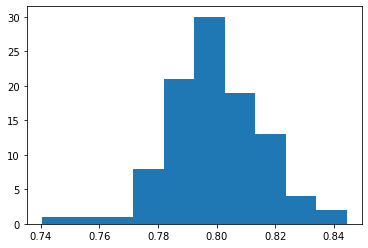

In [13]:
plt.hist(leave["samples"])

In [ ]:
def run_models():
    results = {"date":[], "plugin":[], "leaveout":[]}
    date = pd.Period('2020-02-23', 'D') 
    for _ in trange(65):
        date += 1
        gov_data = pd.read_csv("data/clean/gov_tweets_clean.csv", header = 0, index_col = False, dtype = str)
        gov_data["source"] = "government"
        gov_data = gov_data.loc[gov_data.created_at.notna()]
        gov_data = gov_data.drop(columns = ["index"])
        gov_data["created_at"] = pd.to_datetime(gov_data["created_at"], format = "%a %b %d %H:%M:%S +0000 %Y")
        gov_data["day"] = gov_data.created_at.dt.to_period("D")
        gov_data = gov_data.loc[gov_data["day"] == date].reset_index()

        opp_data = pd.read_csv("data/clean/opp_tweets_clean.csv", header = 0, index_col = False, dtype = str)
        opp_data["source"] = "opposition"
        opp_data = opp_data.loc[opp_data.created_at.notna()]
        opp_data = opp_data.drop(columns = ["index"])
        opp_data["created_at"] = pd.to_datetime(opp_data["created_at"], format = "%a %b %d %H:%M:%S +0000 %Y")
        opp_data["day"] = opp_data.created_at.dt.to_period("D")
        opp_data = opp_data.loc[opp_data["day"] == date].reset_index()


        tweet_data = pd.concat([gov_data, opp_data], axis = 0)
        del(gov_data)
        del(opp_data)
        gc.collect()

        tweet_data.dropna(subset = ["source","preprocessed"], inplace = True)

        model = ModelPolarization(tweet_data["source"].tolist(), tweet_data["user-id_str"].tolist(), tweet_data["preprocessed"].tolist())
        results["date"].append(date)
        results["plugin"].append(model.plug_in())
        results["leaveout"].append(model.leave_out())
    results["date"] = list(map(lambda x: x.strftime("%Y-%m-%d"), results["date"]))
    return results